# Project Description
Dataset: 167 Parameters from Astronomy LSST Project Pipeline DMSTACK.

Objective: Estimate the flux of detected objects (galaxies) using various parameters.

Problem type: Regression


# Imports

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (12,8)})
plt.style.use('ggplot') # better than sns styles.
matplotlib.rcParams['figure.figsize'] = 12,8

import os
import time

# random state
SEED=100
np.random.seed(SEED)

# Jupyter notebook settings for pandas
#pd.set_option('display.float_format', '{:,.2g}'.format) # numbers sep by comma
pd.options.display.float_format = '{:,.5f}'.format # df.A.value_counts().astype(float)
from pandas.api.types import CategoricalDtype
np.set_printoptions(precision=3)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 200)

import IPython
from IPython.display import display, HTML, Image, Markdown

print([(x.__name__,x.__version__) for x in [np, pd,sns,matplotlib]])

[('numpy', '1.17.4'), ('pandas', '0.25.3'), ('seaborn', '0.9.0'), ('matplotlib', '3.1.2')]


In [0]:
%%capture
# capture will not print in notebook

import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    dat_dir = 'drive/My Drive/Colab Notebooks/data/'
    sys.path.append(dat_dir)

    # Also install my custom module
    module_dir = 'drive/My Drive/Colab Notebooks/Bhishan_Modules/' 
    sys.path.append(module_dir)
    !cd drive/My Drive/Colab Notebooks/Bhishan_Modules/
    !pip install -e bhishan
    !cd -

    # pip install
    #!pip install pyldavis
    !pip install hyperopt
    !pip install catboost
    !pip install shap
    !pip install eli5
    #!pip install lime
    #!pip install category_encoders # TargetEncoder
    #!pip install optuna # hyper param opt

    # faster pandas
    # df['x'].swifter.apply(myfunc)
    # df[['x','y']].swifter.apply(myfunc,pos_arg,keyword_arg=mykeyword_arg)
    # !pip install swifter
    
    # update modules
    !pip install -U scikit-learn

    # Note: We need to restart kernel to use tqdm
    # from tqdm.notebook import trange, tqdm
    # tqdm.pandas()
    # out = df['A'].progress_apply(myfunc)
    # !pip install -U tqdm

    # print
    print('Environment: Google Colaboratory.')

In [3]:
import scipy
import sklearn

print([(x.__name__,x.__version__) for x in [scipy, sklearn]])

[('scipy', '1.3.3'), ('sklearn', '0.22')]


In [0]:
# scale and split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [0]:
# regressors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [0]:
# pipeline
from sklearn.pipeline import Pipeline

In [0]:

# metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [0]:
# cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [0]:
df_eval = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

# Useful Scripts

In [0]:
def show_method_attributes(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """

    print(f'Object Type: {type(obj)}\n')
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

In [0]:
def adjustedR2(rsquared,nrows,kcols):
    return rsquared- (kcols-1)/(nrows-kcols) * (1-rsquared)

# Load the Data

In [12]:
ifile = dat_dir + '/flux/processed_0.h5'
df = pd.read_hdf(ifile,key='processed')
print(df.shape)
display(df.info(verbose=False, memory_usage="deep"))

df.head()

(6830, 47)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6830 entries, 6 to 7572
Columns: 47 entries, # calib_detected to base_ClassificationExtendedness_value
dtypes: float32(35), int8(12)
memory usage: 1.0 MB


None

,# calib_detected,deblend_deblendedAsPsf,deblend_tooManyPeaks,deblend_rampedTemplate,base_SdssShape_flag,base_SdssShape_flag_shift,ext_shapeHSM_HsmShapeRegauss_flag,ext_shapeHSM_HsmShapeRegauss_flag_parent_source,ext_shapeHSM_HsmShapeRegauss_flag_galsim,base_PixelFlags_flag_edge,base_Variance_flag,base_Variance_flag_emptyFootprint,coord_ra,coord_dec,parent,deblend_nChild,base_GaussianCentroid_x,base_GaussianCentroid_y,base_NaiveCentroid_x,base_NaiveCentroid_y,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xSigma,base_SdssCentroid_ySigma,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxSigma,base_SdssShape_yySigma,base_SdssShape_xySigma,base_SdssShape_x,base_SdssShape_y,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,ext_shapeHSM_HsmPsfMoments_x,ext_shapeHSM_HsmPsfMoments_y,ext_shapeHSM_HsmPsfMoments_xx,ext_shapeHSM_HsmPsfMoments_yy,ext_shapeHSM_HsmPsfMoments_xy,ext_shapeHSM_HsmSourceMoments_x,ext_shapeHSM_HsmSourceMoments_y,ext_shapeHSM_HsmSourceMoments_xx,ext_shapeHSM_HsmSourceMoments_yy,ext_shapeHSM_HsmSourceMoments_xy,base_GaussianFlux_flux,base_ClassificationExtendedness_value
6,0,0,1,0,0,0,1,1,0,1,0,0,0.0019000000320374966,0.0,0.0,3.0,"1,671.9478759765625",28.217100143432617,"1,671.065673828125",27.989900588989258,"1,671.9385986328125",28.143999099731445,0.0869000032544136,0.0877000018954277,11.427900314331055,11.291399955749512,0.8927000164985657,0.48969998955726624,0.34529998898506165,0.4839000105857849,"1,671.941650390625",28.171499252319336,12.173199653625488,12.25469970703125,0.776199996471405,-0.00019999999494757503,-0.00019999999494757503,12.178999900817871,12.26039981842041,0.7760999798774719,"1,678.829345703125",21.18939971923828,138.0001983642578,124.21060180664062,-112.09300231933594,"8,817.92578125",1.0
7,0,0,1,0,0,0,1,1,0,1,0,0,0.0017999999690800905,0.0,0.0,2.0,"1,782.08544921875",32.915401458740234,"1,782.0118408203125",32.06269836425781,"1,782.11962890625",32.81840133666992,0.08669999986886978,0.09009999781847,11.542099952697754,12.422200202941895,-0.16859999299049377,0.5001999735832214,0.367000013589859,0.5382999777793884,"1,782.11767578125",32.838401794433594,12.177599906921387,12.248299598693848,0.7802000045776367,-0.00019999999494757503,-0.00019999999494757503,12.183300018310547,12.253899574279785,0.7799999713897705,"1,784.5943603515625",28.037399291992188,31.745500564575195,84.89839935302734,-34.8739013671875,"7,491.68115234375",1.0
14,0,0,1,0,0,0,1,1,0,1,0,0,0.0006000000284984708,9.999999747378752e-05,0.0,3.0,"2,952.80908203125",53.15800094604492,"2,952.049560546875",53.00669860839844,"2,952.82861328125",53.12919998168945,0.044199999421834946,0.042500000447034836,12.85159969329834,11.769200325012207,0.521399974822998,0.2639000117778778,0.17870000004768372,0.24160000681877136,"2,952.819580078125",53.140201568603516,11.976799964904785,11.97659969329834,0.7926999926567078,-0.0,9.999999747378752e-05,11.982999801635742,11.982600212097168,0.7929999828338623,"2,958.09326171875",45.07320022583008,69.85030364990234,140.94479370117188,-81.05059814453125,"18,482.126953125",1.0
16,0,0,1,0,0,0,1,1,0,1,0,0,0.0024999999441206455,0.0,0.0,3.0,989.6881713867188,26.528900146484375,989.0255126953125,26.02549934387207,989.9041137695312,26.556400299072266,0.05510000139474869,0.04490000009536743,75.09269714355469,15.560799598693848,13.81760025024414,1.5398000478744507,0.534600019454956,0.3190999925136566,991.847900390625,26.871000289916992,12.03339958190918,12.240699768066406,0.7476000189781189,-0.00019999999494757503,-0.00019999999494757503,12.039600372314453,12.246100425720215,0.7476999759674072,993.5673217773438,27.14240074157715,72.79850006103516,14.63949966430664,12.477899551391602,"14,024.1572265625",1.0
21,0,0,0,0,0,0,1,0,1,1,0,0,0.0010000000474974513,0.0,0.0,0.0,"2,529.72802734375",22.630599975585938,"2,529.062744140625",22.03700065612793,"2,529.734375",22.628400802612305,0.07119999825954437,0.07109999656677246,10.858400344848633,10.890999794006348,0.861599981784820

In [13]:
df.columns.to_numpy()

array(['# calib_detected', 'deblend_deblendedAsPsf',
       'deblend_tooManyPeaks', 'deblend_rampedTemplate',
       'base_SdssShape_flag', 'base_SdssShape_flag_shift',
       'ext_shapeHSM_HsmShapeRegauss_flag',
       'ext_shapeHSM_HsmShapeRegauss_flag_parent_source',
       'ext_shapeHSM_HsmShapeRegauss_flag_galsim',
       'base_PixelFlags_flag_edge', 'base_Variance_flag',
       'base_Variance_flag_emptyFootprint', 'coord_ra', 'coord_dec',
       'parent', 'deblend_nChild', 'base_GaussianCentroid_x',
       'base_GaussianCentroid_y', 'base_NaiveCentroid_x',
       'base_NaiveCentroid_y', 'base_SdssCentroid_x',
       'base_SdssCentroid_y', 'base_SdssCentroid_xSigma',
       'base_SdssCentroid_ySigma', 'base_SdssShape_xx',
       'base_SdssShape_yy', 'base_SdssShape_xy', 'base_SdssShape_xxSigma',
       'base_SdssShape_yySigma', 'base_SdssShape_xySigma',
       'base_SdssShape_x', 'base_SdssShape_y', 'base_SdssShape_psf_xx',
       'base_SdssShape_psf_yy', 'base_SdssShape_psf_xy',


# Target Distribution

In [14]:
target = 'base_GaussianFlux_flux'
df[target].describe()

count               6,830.0
mean         24,742.7265625
std         54,128.16796875
min       837.2340698242188
25%     3,271.5199584960938
50%       6,683.18408203125
75%       16,975.2958984375
max             526,191.125
Name: base_GaussianFlux_flux, dtype: float64

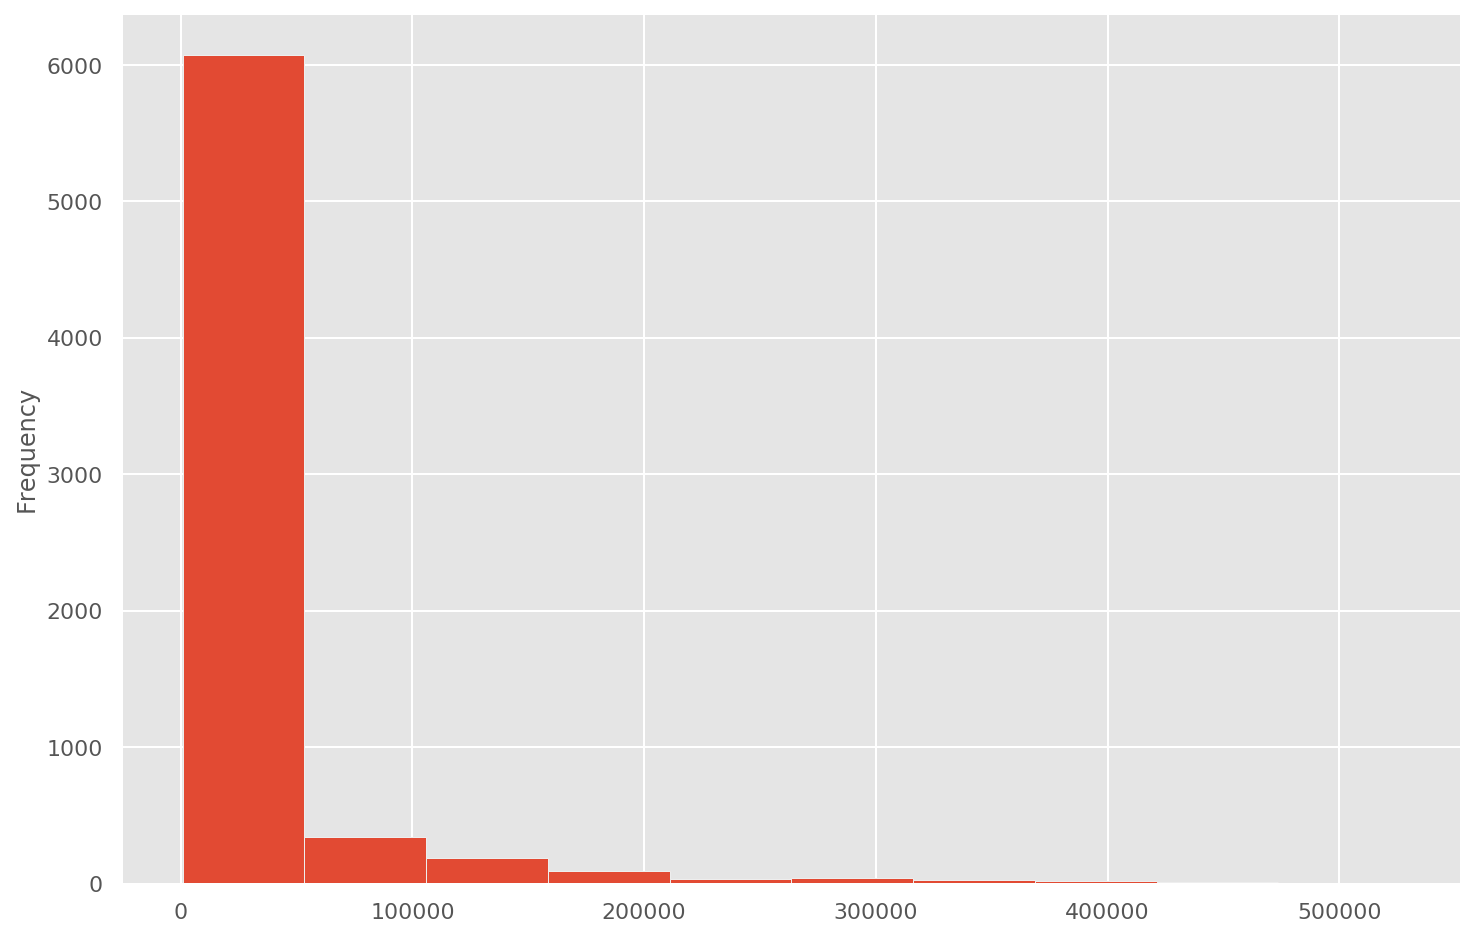

In [15]:
df[target].plot(kind='hist')

# Train-Test split

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split (df.drop(target,axis=1),df[target],
                                                     test_size=0.20,
                                                     random_state=SEED)

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((5464, 46), (5464,), (1366, 46), (1366,))

# Making pipeline for various sklearn Regressors (with automatic scaling)

In [17]:
%%time

pipelines = []

pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),
                                    ('LR',LinearRegression(n_jobs=-1))])) )


pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),
                                           ('LASSO', Lasso())])))

pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),
                                        ('EN', ElasticNet())])))

pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),
                                         ('KNN', KNeighborsRegressor(n_jobs=-1))])))

# decision tree may not need scaling
pipelines.append(('ScaledDT', Pipeline([('DT', DecisionTreeRegressor(
                random_state=SEED,max_features=0.9))])))

# random forest may not need scaling
pipelines.append(('RF', Pipeline([('RF', RandomForestRegressor(
                random_state=SEED,n_jobs=-1))])))

# boosting may not need scaling
pipelines.append(('ScaledGBR', Pipeline([('Scaler', StandardScaler()),
                                         ('GBR', GradientBoostingRegressor(
                random_state=SEED,n_estimators=500,max_features=0.9))])))


df_cv = pd.DataFrame({'Model': [],
                      '5-Fold Cross Validation Mean':[],
                      '5-Fold Cross Validation Std':[]
                     })

# pipeline will scale the data and then fit the data
for name, model in pipelines:
    kfold = KFold(n_splits=5, random_state=SEED,shuffle=True)
    cv_results = cross_val_score(model,
                                 Xtrain,
                                 ytrain,
                                 cv=kfold,
                                 verbose=True,
                                 scoring='neg_mean_squared_error'
                                 )
    # add cv result to dataframe
    df_cv.loc[len(df_cv)] = [name, cv_results.mean(), cv_results.std() ]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2123841667072.0, tolerance: 1355507712.0
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1687406772224.0, tolerance: 1302479488.0
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2209787674624.0, tolerance: 1277311360.0
  positive)
/us

CPU times: user 1min 44s, sys: 1.55 s, total: 1min 45s
Wall time: 2min 27s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [18]:
# print cv results
# smallest rmse is best, largest negMSE is best.
df_cv.sort_values('5-Fold Cross Validation Mean',ascending=False).round(0)

,Model,5-Fold Cross Validation Mean,5-Fold Cross Validation Std
6,ScaledGBR,"-22,083,671.0","6,486,983.0"
5,RF,"-40,279,180.0","12,770,752.0"
4,ScaledDT,"-81,997,933.0","30,263,650.0"
1,ScaledLASSO,"-1,372,721,587.0","141,372,454.0"
0,ScaledLR,"-1,375,816,422.0","135,184,433.0"
2,ScaledEN,"-1,418,742,016.0","145,946,496.0"
3,ScaledKNN,"-1,508,560,896.0","133,392,429.0"


In [19]:
df_cv['5-Fold Cross Validation Mean'].max() # for cross validation always higher is better

-22083670.818400282

# Random Forest

In [20]:
%%time

model = RandomForestRegressor(n_estimators= 1000,
                              random_state=SEED,
                              n_jobs=-1,
                                )

# nested cross validation      
kfold = KFold(n_splits=5, random_state=SEED,shuffle=True)
cv_results = cross_val_score(model,
                                Xtrain,
                                ytrain,
                                cv=kfold,
                                verbose=True,
                                scoring='neg_mean_squared_error'
                                )
# add cv result to dataframe
df_cv.loc[len(df_cv)] = [name, cv_results.mean(), cv_results.std() ]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 16.5 s, sys: 3.38 s, total: 19.9 s
Wall time: 7min 4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.1min finished


In [21]:
df_cv.sort_values('5-Fold Cross Validation Mean',ascending=False).round(0)

,Model,5-Fold Cross Validation Mean,5-Fold Cross Validation Std
6,ScaledGBR,"-22,083,671.0","6,486,983.0"
7,ScaledGBR,"-38,689,095.0","14,191,490.0"
5,RF,"-40,279,180.0","12,770,752.0"
4,ScaledDT,"-81,997,933.0","30,263,650.0"
1,ScaledLASSO,"-1,372,721,587.0","141,372,454.0"
0,ScaledLR,"-1,375,816,422.0","135,184,433.0"
2,ScaledEN,"-1,418,742,016.0","145,946,496.0"
3,ScaledKNN,"-1,508,560,896.0","133,392,429.0"


# Gradient Boosting

In [0]:
Xtr = Xtrain
ytr = ytrain
Xtx = Xtest
ytx = ytest

In [35]:
model = GradientBoostingRegressor()
model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
time_start = time.time()

model = GradientBoostingRegressor(random_state=SEED)
model.fit(Xtr, ytr)

ypreds = model.predict(Xtx)

r2 = sklearn.metrics.r2_score(ytx, ypreds)
ar2 = adjustedR2(r2, Xtx.shape[0], Xtx.shape[1])
ar2 = round(ar2,6)

time_taken = time.time() - time_start
m,s = divmod(time_taken,60)
print(f'AR2: {ar2} , Time taken: {m} min {s:.0f} sec')

AR2: 0.995264 , Time taken: 0.0 min 6 sec


# Gradient Boosting Hyper Parameter Optimization

## Model Complexity
n_estimators, depth

In [22]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# we use gradient boosting regressor, since it gave us the best model.

param_grid = dict(n_estimators=np.array([400,500,600,700,800,1000]))

model = GradientBoostingRegressor(random_state=SEED)
kfold = KFold(n_splits=5, random_state=SEED,shuffle=True)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    verbose=50,
                    cv=kfold)

grid_result = grid.fit(Xtrain, ytrain)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=400 ................................................
[CV] ............ n_estimators=400, score=-29411524.233, total=  17.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.8s remaining:    0.0s
[CV] n_estimators=400 ................................................
[CV] ............ n_estimators=400, score=-26718843.027, total=  17.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.6s remaining:    0.0s
[CV] n_estimators=400 ................................................
[CV] ............ n_estimators=400, score=-23539409.634, total=  17.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.4s remaining:    0.0s
[CV] n_estimators=400 ................................................
[CV] ............ n_estimators=400, score=-20130804.411, total=  17.8s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

In [23]:
means       = grid_result.cv_results_['mean_test_score']
stds        = grid_result.cv_results_['std_test_score']
params      = grid_result.cv_results_['params']
df_grid_gbr = pd.DataFrame({'n_estimators': params,
                           'neg_mean_squared_error': means,
                           'std': stds})

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
pd.set_option('display.float_format', '{:,.0f}'.format)
df_grid_gbr.sort_values('neg_mean_squared_error', ascending=False)

Best: -21686530.001465 using {'n_estimators': 1000}


,n_estimators,neg_mean_squared_error,std
5,{'n_estimators': 1000},"-21,686,530","5,052,977"
4,{'n_estimators': 800},"-21,821,644","5,061,134"
3,{'n_estimators': 700},"-21,942,819","5,096,071"
2,{'n_estimators': 600},"-22,164,969","5,112,064"
1,{'n_estimators': 500},"-22,429,077","5,142,653"
0,{'n_estimators': 400},"-22,891,999","5,156,894"


In [24]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# we use gradient boosting regressor, since it gave us the best model.

param_grid = dict(n_estimators=np.array([2000,3000,4000]))

model = GradientBoostingRegressor(random_state=SEED)
kfold = KFold(n_splits=5, random_state=SEED,shuffle=True)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    verbose=50,
                    cv=kfold)

grid_result = grid.fit(Xtrain, ytrain)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=2000 ...............................................
[CV] ........... n_estimators=2000, score=-28072765.493, total= 1.5min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s
[CV] n_estimators=2000 ...............................................
[CV] ........... n_estimators=2000, score=-25048541.373, total= 1.5min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s
[CV] n_estimators=2000 ...............................................
[CV] ........... n_estimators=2000, score=-21951165.390, total= 1.5min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min remaining:    0.0s
[CV] n_estimators=2000 ...............................................
[CV] ........... n_estimators=2000, score=-18974736.730, total= 1.5min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

In [25]:
means       = grid_result.cv_results_['mean_test_score']
stds        = grid_result.cv_results_['std_test_score']
params      = grid_result.cv_results_['params']
df_grid_gbr = pd.DataFrame({'n_estimators': params,
                           'neg_mean_squared_error': means,
                           'std': stds})

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
pd.set_option('display.float_format', '{:,.0f}'.format)
df_grid_gbr.sort_values('neg_mean_squared_error', ascending=False)

Best: -21435018.112703 using {'n_estimators': 4000}


,n_estimators,neg_mean_squared_error,std
2,{'n_estimators': 4000},"-21,435,018","5,080,157"
1,{'n_estimators': 3000},"-21,443,801","5,075,322"
0,{'n_estimators': 2000},"-21,485,632","5,065,409"


In [32]:
time_start = time.time()

model = GradientBoostingRegressor(random_state=SEED,n_estimators=4_000)
model.fit(Xtr, ytr)

ypreds = model.predict(Xtx)

r2 = sklearn.metrics.r2_score(ytx, ypreds)
ar2 = adjustedR2(r2, Xtx.shape[0], Xtx.shape[1])
ar2 = round(ar2,6)

time_taken = time.time() - time_start
m,s = divmod(time_taken,60)
print(f'AR2: {ar2} , Time taken: {m} min {s:.0f} sec')

AR2: 0.997885 , Time taken: 3.0 min 46 sec


In [44]:
model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
for n in [3]: # default max_depth = 3
    time_start = time.time()
    param = 'depth'
    model = GradientBoostingRegressor(verbose=False,random_state=SEED,
                              n_estimators=4000,
                              max_depth=n,
                              )
    model.fit(Xtr, ytr)
    ypreds = model.predict(Xtx)
    r2 = sklearn.metrics.r2_score(ytx, ypreds)
    ar2 = adjustedR2(r2, Xtx.shape[0], Xtx.shape[1])
    ar2 = round(ar2,6)

    time_taken = time.time() - time_start
    m,s = divmod(time_taken,60)
    print(f'{param}: {n}, AR2: {ar2} , Time taken: {m} min {s:.0f} sec')

"""
depth: 2, AR2: 0.996209 , Time taken: 2.0 min 32 sec
depth: 3, AR2: 0.997885 , Time taken: 3.0 min 45 sec **best
depth: 4, AR2: 0.997314 , Time taken: 4.0 min 57 sec
depth: 5, AR2: 0.997327 , Time taken: 6.0 min 8 sec
depth: 6, AR2: 0.996715 , Time taken: 7.0 min 20 sec
"""

## Model Regularization
alpha, learning_rate, ccp_alpha

In [49]:
model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=4000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=100, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=False,
                          warm_start=False)

In [50]:
for n in [0.9]: # default alpha = 0.9
    time_start = time.time()
    param = 'alpha'
    model = GradientBoostingRegressor(verbose=1000,random_state=SEED,
                              n_estimators=4000,
                              max_depth=3,
                              alpha=n,
                              )
    model.fit(Xtr, ytr)
    ypreds = model.predict(Xtx)
    r2 = sklearn.metrics.r2_score(ytx, ypreds)
    ar2 = adjustedR2(r2, Xtx.shape[0], Xtx.shape[1])
    ar2 = round(ar2,6)

    time_taken = time.time() - time_start
    m,s = divmod(time_taken,60)
    print(f'{param}: {n}, AR2: {ar2} , Time taken: {m} min {s:.0f} sec')

"""
alpha: 0.7, AR2:  0.997885 , Time taken: 3.0 min 46 sec
alpha: 0.8, AR2:  0.997885 , Time taken: 3.0 min 46 sec
alpha: 0.9, AR2:  0.997885 , Time taken: 3.0 min 45 sec
alpha: 0.99, AR2: 0.997885 , Time taken: 3.0 min 45 sec
""";

alpha: 0.7, AR2: 0.997885 , Time taken: 3.0 min 46 sec
alpha: 0.8, AR2: 0.997885 , Time taken: 3.0 min 46 sec
alpha: 0.9, AR2: 0.997885 , Time taken: 3.0 min 45 sec
alpha: 0.99, AR2: 0.997885 , Time taken: 3.0 min 45 sec


'\n\n'

In [54]:
for n in [0.1]: # default learning_rate = 0.1
    time_start = time.time()
    param = 'learning_rate'
    model = GradientBoostingRegressor(verbose=False,random_state=SEED,
                              n_estimators=4000,
                              max_depth=3,
                              alpha=0.9,
                              learning_rate =n,
                              )
    model.fit(Xtr, ytr)
    ypreds = model.predict(Xtx)
    r2 = sklearn.metrics.r2_score(ytx, ypreds)
    ar2 = adjustedR2(r2, Xtx.shape[0], Xtx.shape[1])
    ar2 = round(ar2,6)

    time_taken = time.time() - time_start
    m,s = divmod(time_taken,60)
    print(f'{param}: {n}, AR2: {ar2} , Time taken: {m} min {s:.0f} sec')

"""
learning_rate: 0.01, AR2: 0.997582 , Time taken: 3.0 min 45 sec
learning_rate: 0.1,  AR2: 0.997885 , Time taken: 3.0 min 45 sec **best
learning_rate: 0.11, AR2: 0.996815 , Time taken: 3.0 min 45 sec
learning_rate: 0.15, AR2: 0.99731 , Time taken: 3.0 min 45 sec
learning_rate: 0.2,  AR2: 0.997367 , Time taken: 3.0 min 45 sec
learning_rate: 0.3,  AR2: 0.994931 , Time taken: 3.0 min 45 sec
""";

learning_rate: 0.01, AR2: 0.997582 , Time taken: 3.0 min 45 sec
learning_rate: 0.1, AR2: 0.997885 , Time taken: 3.0 min 45 sec
learning_rate: 0.11, AR2: 0.996815 , Time taken: 3.0 min 45 sec
learning_rate: 0.15, AR2: 0.99731 , Time taken: 3.0 min 45 sec
learning_rate: 0.2, AR2: 0.997367 , Time taken: 3.0 min 45 sec
learning_rate: 0.3, AR2: 0.994931 , Time taken: 3.0 min 45 sec


# Best Model

In [55]:
time_start = time.time()

model = GradientBoostingRegressor(verbose=False,random_state=SEED,
                            n_estimators=4000,
                            max_depth=3,
                            alpha=0.1,
                            learning_rate =0.1,
                            )
model.fit(Xtr, ytr)
ypreds = model.predict(Xtx)
r2 = sklearn.metrics.r2_score(ytx, ypreds)
ar2 = adjustedR2(r2, Xtx.shape[0], Xtx.shape[1])
ar2 = round(ar2,6)

time_taken = time.time() - time_start
m,s = divmod(time_taken,60)
print(f'AR2: {ar2} , Time taken: {m} min {s:.0f} sec')

AR2: 0.997885 , Time taken: 3.0 min 45 sec


# Feature Importance

In [58]:
df.shape, Xtrain.shape

((6830, 47), (5464, 46))

In [56]:
show_method_attributes(model)

Object Type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>



,0,1,2,3,4,5,6
0,alpha,fit,loss_,min_impurity_split,n_estimators_,random_state,tol
1,apply,get_params,max_depth,min_samples_leaf,n_features_,score,train_score_
2,ccp_alpha,init,max_features,min_samples_split,n_iter_no_change,set_params,validation_fraction
3,criterion,init_,max_features_,min_weight_fraction_leaf,predict,staged_predict,verbose
4,estimators_,learning_rate,max_leaf_nodes,n_classes_,presort,subsample,warm_start
5,feature_importances_,loss,min_impurity_decrease,n_estimators,,,


In [65]:
df_fimp = pd.DataFrame({'Feature': df.columns.drop(target) })
df_fimp['Importance'] = model.feature_importances_

df_fimp.sort_values('Importance',ascending=False)

,Feature,Importance
28,base_SdssShape_yySigma,0.56726
29,base_SdssShape_xySigma,0.19374
27,base_SdssShape_xxSigma,0.08237
25,base_SdssShape_yy,0.03861
43,ext_shapeHSM_HsmSourceMoments_yy,0.03063
23,base_SdssCentroid_ySigma,0.02962
42,ext_shapeHSM_HsmSourceMoments_xx,0.02359
24,base_SdssShape_xx,0.01347
22,base_SdssCentroid_xSigma,0.01202
45,base_ClassificationExtendedness_value,0.00487


In [68]:
cols_low_imp = df_fimp.query("Importance < 0.00002")['Feature'].to_list()
cols_low_imp

['deblend_deblendedAsPsf',
 'deblend_tooManyPeaks',
 'deblend_rampedTemplate',
 'base_SdssShape_flag',
 'base_SdssShape_flag_shift',
 'ext_shapeHSM_HsmShapeRegauss_flag',
 'ext_shapeHSM_HsmShapeRegauss_flag_parent_source',
 'ext_shapeHSM_HsmShapeRegauss_flag_galsim',
 'base_PixelFlags_flag_edge',
 'base_Variance_flag',
 'base_Variance_flag_emptyFootprint',
 'coord_dec',
 'parent',
 'base_GaussianCentroid_x',
 'base_GaussianCentroid_y',
 'base_NaiveCentroid_x',
 'base_NaiveCentroid_y',
 'base_SdssCentroid_x',
 'base_SdssCentroid_y',
 'base_SdssShape_x',
 'base_SdssShape_y',
 'ext_shapeHSM_HsmPsfMoments_x',
 'ext_shapeHSM_HsmSourceMoments_x',
 'ext_shapeHSM_HsmSourceMoments_y']

In [0]:
df2 = df.drop(cols_low_imp,axis=1)

Xtr2, Xtx2, ytr2, ytx2 = train_test_split(df2.drop(target,axis=1),
                                      df2[target],
                                      test_size=0.2,
                                      random_state=SEED)

In [71]:
time_start = time.time()
Xtr = Xtr2
Xtx = Xtx2
ytr = ytr2
ytx = ytx2


model = GradientBoostingRegressor(verbose=False,random_state=SEED,
                            n_estimators=4000,
                            max_depth=3,
                            alpha=0.1,
                            learning_rate =0.1,
                            )
model.fit(Xtr, ytr)
ypreds = model.predict(Xtx)
r2 = sklearn.metrics.r2_score(ytx, ypreds)
ar2 = adjustedR2(r2, Xtx.shape[0], Xtx.shape[1])
ar2 = round(ar2,6)

time_taken = time.time() - time_start
m,s = divmod(time_taken,60)
print(f'AR2: {ar2} , Time taken: {m} min {s:.0f} sec')

AR2: 0.997935 , Time taken: 2.0 min 15 sec


In [82]:
feature_names = df.columns.drop(cols_low_imp + [target]).to_list()
df_fimp = pd.DataFrame({'Feature': feature_names })
df_fimp['Importance'] = model.feature_importances_

df_fimp.sort_values('Importance',ascending=False).style.background_gradient(subset=['Importance'])

,Feature,Importance
9,base_SdssShape_yySigma,0.567571
10,base_SdssShape_xySigma,0.194248
8,base_SdssShape_xxSigma,0.0823462
6,base_SdssShape_yy,0.0349603
19,ext_shapeHSM_HsmSourceMoments_yy,0.0306536
4,base_SdssCentroid_ySigma,0.029289
5,base_SdssShape_xx,0.0233338
18,ext_shapeHSM_HsmSourceMoments_xx,0.018103
3,base_SdssCentroid_xSigma,0.012025
21,base_ClassificationExtendedness_value,0.00487649


# Model Evaluation

In [75]:
import eli5

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [81]:
eli5.show_weights(model,feature_names=feature_names,top=10)

Weight,Feature
0.5676 ± 0.3050,base_SdssShape_yySigma
0.1942 ± 0.3725,base_SdssShape_xySigma
0.0823 ± 0.2874,base_SdssShape_xxSigma
0.0350 ± 0.3057,base_SdssShape_yy
0.0307 ± 0.3007,ext_shapeHSM_HsmSourceMoments_yy
0.0293 ± 0.2440,base_SdssCentroid_ySigma
0.0233 ± 0.2665,base_SdssShape_xx
0.0181 ± 0.2684,ext_shapeHSM_HsmSourceMoments_xx
0.0120 ± 0.2400,base_SdssCentroid_xSigma
0.0049 ± 0.0491,base_ClassificationExtendedness_value
